In [17]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
# Suppress all warnings
import warnings
warnings.simplefilter("ignore")

# Feature Engineering

In [5]:
# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct'

# Import data with specific columns
df = pd.read_csv('df_post_eda.csv', usecols=['Date', pred_var])

# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Group by 'Date' to ensure there is one unique value per date
df = df.groupby('Date').mean()

# Reset the index to convert the 'Date' index back to a column
df.reset_index(inplace=True)

# Rename the columns for compatibility with Prophet
df.rename(columns={'Date': 'ds', pred_var: 'y'}, inplace=True)

# Print the shape of the dataframe and the first few rows to verify
print(df.shape)
df.head()


(80, 2)


,ds,y
0,2021-11-03,10.332812
1,2021-11-10,13.185937
2,2021-11-17,15.871875
3,2021-11-24,18.675000
4,2021-12-01,20.689062


In [12]:
df.tail()

,ds,y
75,2023-04-12,50.951563
76,2023-04-19,51.012500
77,2023-04-26,51.034375
78,2023-05-03,51.064062
79,2023-05-10,51.076563


In [6]:
# Calculate the index for the 70-30 split
split_index = int(len(df) * 0.7)

# Split into train and test
train = df.iloc[:split_index]
test = df.iloc[split_index:]

print(train.shape, test.shape)

# Initialize and fit the Prophet model on the training data
model = Prophet()
model.fit(train[['ds', 'y']])

# Make predictions on the training set
train_pred = model.predict(train[['ds']])
train_pred = train_pred.set_index('ds')

(56, 2) (24, 2)


23:59:54 - cmdstanpy - INFO - Chain [1] start processing
23:59:56 - cmdstanpy - INFO - Chain [1] done processing


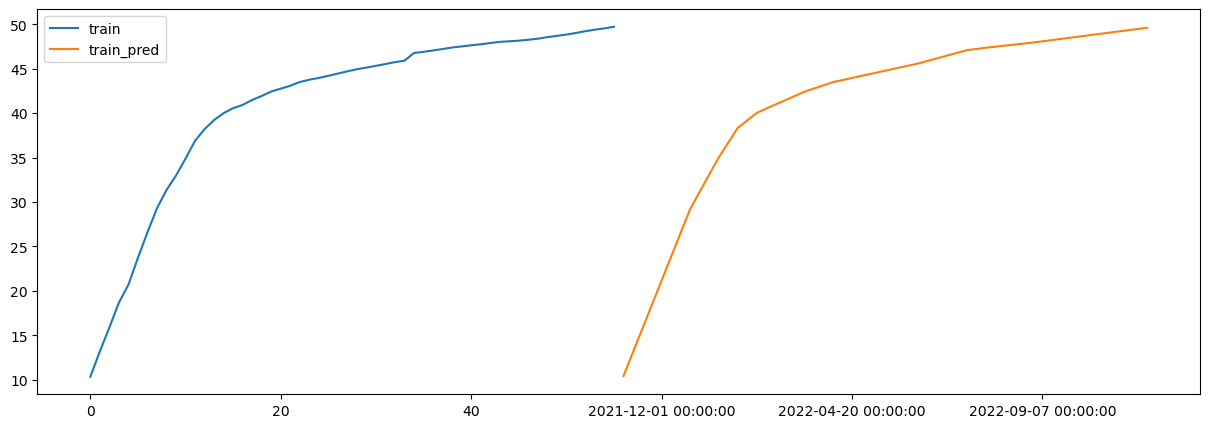

In [7]:
# Plot the training predictions
pd.concat([train['y'], train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

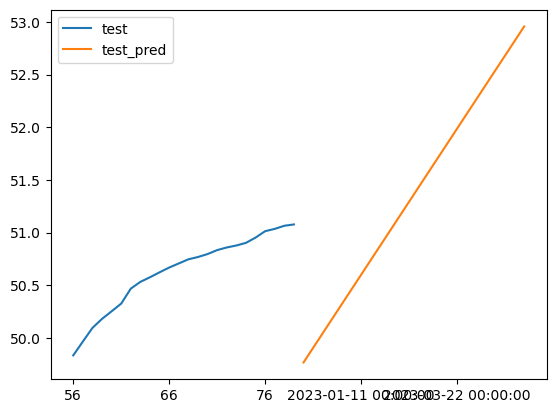

In [8]:
# Make predictions on the test set
test_pred = model.predict(test[['ds']])
test_pred = test_pred.set_index('ds')

# Plot the test predictions
pd.concat([test['y'], test_pred['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [9]:
# Calculate RMSE for the training set
train_rmse = sqrt(mean_squared_error(train['y'], train_pred['yhat']))
print(f"Train RMSE: {train_rmse}")

# Calculate RMSE for the test set
test_rmse = sqrt(mean_squared_error(test['y'], test_pred['yhat']))
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.11644967428298858
Test RMSE: 0.964760938339838


# Tuning

In [14]:
# Initialize the Prophet model with multiplicative seasonality
model = Prophet(seasonality_mode='multiplicative')  # or 'additive', depending on your data

# Add custom seasonality
model.add_seasonality(name='monthly', period=24, fourier_order=5)

# Fit the model to your dataframe 'df'
model.fit(df)

# Set the parameters for cross-validation
initial = '364 days'  # Start with 1 year of data as the initial training set
period = '84 days'   # Set the period for cross-validation to 3 months
horizon = '28 days'   # Set the horizon for forecasting to 1 month

# Perform cross-validation
df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon)

# Calculate performance metrics
df_p = performance_metrics(df_cv)

# Print performance metrics
print(df_p)

00:08:48 - cmdstanpy - INFO - Chain [1] start processing
00:08:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

00:08:48 - cmdstanpy - INFO - Chain [1] start processing
00:08:49 - cmdstanpy - INFO - Chain [1] done processing
00:08:49 - cmdstanpy - INFO - Chain [1] start processing
00:08:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon       mse      rmse       mae      mape     mdape     smape  \
0  7 days  0.023454  0.153147  0.135139  0.002667  0.002667  0.002662   
1 14 days  0.103178  0.321213  0.266256  0.005253  0.005253  0.005233   
2 21 days  0.142568  0.377581  0.318632  0.006280  0.006280  0.006252   
3 28 days  0.155439  0.394258  0.330849  0.006516  0.006516  0.006486   

   coverage  
0       0.5  
1       0.5  
2       0.5  
3       0.5  


In [18]:
# Initialize variables for tuning
best_fourier_order = 1
best_rmse = float('inf')
best_model = None
best_metrics = None

# Define the range of fourier orders you want to test
fourier_orders = range(1, 21)  # For example, testing 1 through 20

for fourier_order in fourier_orders:
    # Initialize the Prophet model with the current fourier_order
    model = Prophet(seasonality_mode='multiplicative')
    model.add_seasonality(name='weekly', period=7, fourier_order=fourier_order)
    model.add_seasonality(name='yearly', period=365.25, fourier_order=fourier_order)
    
    # Fit the model
    model.fit(df)
    
    # Perform cross-validation
    df_cv = cross_validation(model, initial='364 days', period='84 days', horizon='28 days')
    
    # Calculate performance metrics
    df_p = performance_metrics(df_cv)
    current_rmse = np.mean(df_p['rmse'])
    
    # If the current model is better than the previous best, update best_model
    if current_rmse < best_rmse:
        best_rmse = current_rmse
        best_fourier_order = fourier_order
        best_model = model
        best_metrics = df_p

# Print the best results
print(f"Best Fourier Order: {best_fourier_order}")
print(f"Best RMSE: {best_rmse}")
print(best_metrics)


00:13:09 - cmdstanpy - INFO - Chain [1] start processing
00:13:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:13:12 - cmdstanpy - INFO - Chain [1] start processing
00:13:13 - cmdstanpy - INFO - Chain [1] done processing
00:13:13 - cmdstanpy - INFO - Chain [1] start processing
00:13:14 - cmdstanpy - INFO - Chain [1] done processing
00:13:15 - cmdstanpy - INFO - Chain [1] start processing
00:13:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:13:16 - cmdstanpy - INFO - Chain [1] start processing
00:13:18 - cmdstanpy - INFO - Chain [1] done processing
00:13:18 - cmdstanpy - INFO - Chain [1] start processing
00:13:20 - cmdstanpy - INFO - Chain [1] done processing
00:13:20 - cmdstanpy - INFO - Chain [1] start processing
00:13:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:13:24 - cmdstanpy - INFO - Chain [1] start processing
00:13:26 - cmdstanpy - INFO - Chain [1] done processing
00:13:26 - cmdstanpy - INFO - Chain [1] start processing
00:13:30 - cmdstanpy - INFO - Chain [1] done processing
00:13:30 - cmdstanpy - INFO - Chain [1] start processing
00:13:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:13:34 - cmdstanpy - INFO - Chain [1] start processing
00:13:37 - cmdstanpy - INFO - Chain [1] done processing
00:13:37 - cmdstanpy - INFO - Chain [1] start processing
00:13:44 - cmdstanpy - INFO - Chain [1] done processing
00:13:44 - cmdstanpy - INFO - Chain [1] start processing
00:13:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:13:49 - cmdstanpy - INFO - Chain [1] start processing
00:13:54 - cmdstanpy - INFO - Chain [1] done processing
00:13:54 - cmdstanpy - INFO - Chain [1] start processing
00:13:59 - cmdstanpy - INFO - Chain [1] done processing
00:14:00 - cmdstanpy - INFO - Chain [1] start processing
00:14:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:14:09 - cmdstanpy - INFO - Chain [1] start processing
00:14:16 - cmdstanpy - INFO - Chain [1] done processing
00:14:16 - cmdstanpy - INFO - Chain [1] start processing
00:14:25 - cmdstanpy - INFO - Chain [1] done processing
00:14:25 - cmdstanpy - INFO - Chain [1] start processing
00:14:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:14:33 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:46 - cmdstanpy - INFO - Chain [1] done processing
00:14:47 - cmdstanpy - INFO - Chain [1] start processing
00:14:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:14:55 - cmdstanpy - INFO - Chain [1] start processing
00:14:55 - cmdstanpy - INFO - Chain [1] done processing
00:14:56 - cmdstanpy - INFO - Chain [1] start processing
00:15:04 - cmdstanpy - INFO - Chain [1] done processing
00:15:05 - cmdstanpy - INFO - Chain [1] start processing
00:15:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:15:12 - cmdstanpy - INFO - Chain [1] start processing
00:15:13 - cmdstanpy - INFO - Chain [1] done processing
00:15:13 - cmdstanpy - INFO - Chain [1] start processing
00:15:24 - cmdstanpy - INFO - Chain [1] done processing
00:15:24 - cmdstanpy - INFO - Chain [1] start processing
00:15:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:15:32 - cmdstanpy - INFO - Chain [1] start processing
00:15:44 - cmdstanpy - INFO - Chain [1] done processing
00:15:44 - cmdstanpy - INFO - Chain [1] start processing
00:16:00 - cmdstanpy - INFO - Chain [1] done processing
00:16:00 - cmdstanpy - INFO - Chain [1] start processing
00:16:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:16:16 - cmdstanpy - INFO - Chain [1] start processing
00:16:35 - cmdstanpy - INFO - Chain [1] done processing
00:16:36 - cmdstanpy - INFO - Chain [1] start processing
00:16:49 - cmdstanpy - INFO - Chain [1] done processing
00:16:50 - cmdstanpy - INFO - Chain [1] start processing
00:17:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:17:04 - cmdstanpy - INFO - Chain [1] start processing
00:17:18 - cmdstanpy - INFO - Chain [1] done processing
00:17:19 - cmdstanpy - INFO - Chain [1] start processing
00:17:35 - cmdstanpy - INFO - Chain [1] done processing
00:17:36 - cmdstanpy - INFO - Chain [1] start processing
00:17:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:17:48 - cmdstanpy - INFO - Chain [1] start processing
00:18:06 - cmdstanpy - INFO - Chain [1] done processing
00:18:06 - cmdstanpy - INFO - Chain [1] start processing
00:18:18 - cmdstanpy - INFO - Chain [1] done processing
00:18:18 - cmdstanpy - INFO - Chain [1] start processing
00:18:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:18:27 - cmdstanpy - INFO - Chain [1] start processing
00:18:38 - cmdstanpy - INFO - Chain [1] done processing
00:18:38 - cmdstanpy - INFO - Chain [1] start processing
00:18:49 - cmdstanpy - INFO - Chain [1] done processing
00:18:49 - cmdstanpy - INFO - Chain [1] start processing
00:18:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:18:58 - cmdstanpy - INFO - Chain [1] start processing
00:19:15 - cmdstanpy - INFO - Chain [1] done processing
00:19:15 - cmdstanpy - INFO - Chain [1] start processing
00:19:25 - cmdstanpy - INFO - Chain [1] done processing
00:19:26 - cmdstanpy - INFO - Chain [1] start processing
00:19:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:19:39 - cmdstanpy - INFO - Chain [1] start processing
00:19:40 - cmdstanpy - INFO - Chain [1] done processing
00:19:40 - cmdstanpy - INFO - Chain [1] start processing
00:20:01 - cmdstanpy - INFO - Chain [1] done processing
00:20:01 - cmdstanpy - INFO - Chain [1] start processing
00:20:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:20:23 - cmdstanpy - INFO - Chain [1] start processing
00:20:52 - cmdstanpy - INFO - Chain [1] done processing
00:20:52 - cmdstanpy - INFO - Chain [1] start processing
00:21:25 - cmdstanpy - INFO - Chain [1] done processing
00:21:26 - cmdstanpy - INFO - Chain [1] start processing
00:21:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:21:50 - cmdstanpy - INFO - Chain [1] start processing
00:22:21 - cmdstanpy - INFO - Chain [1] done processing
00:22:21 - cmdstanpy - INFO - Chain [1] start processing
00:22:45 - cmdstanpy - INFO - Chain [1] done processing
00:22:45 - cmdstanpy - INFO - Chain [1] start processing
00:23:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:23:06 - cmdstanpy - INFO - Chain [1] start processing
00:23:31 - cmdstanpy - INFO - Chain [1] done processing
00:23:31 - cmdstanpy - INFO - Chain [1] start processing
00:23:58 - cmdstanpy - INFO - Chain [1] done processing
00:23:59 - cmdstanpy - INFO - Chain [1] start processing
00:24:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

00:24:15 - cmdstanpy - INFO - Chain [1] start processing
00:24:16 - cmdstanpy - INFO - Chain [1] done processing
00:24:16 - cmdstanpy - INFO - Chain [1] start processing
00:24:49 - cmdstanpy - INFO - Chain [1] done processing


Best Fourier Order: 3
Best RMSE: 0.024252465566972643
  horizon       mse      rmse       mae      mape     mdape     smape  \
0  7 days  0.001115  0.033384  0.028616  0.000562  0.000562  0.000562   
1 14 days  0.000946  0.030760  0.029567  0.000581  0.000581  0.000581   
2 21 days  0.000753  0.027432  0.026365  0.000518  0.000518  0.000518   
3 28 days  0.000030  0.005433  0.005392  0.000106  0.000106  0.000106   

   coverage  
0       1.0  
1       1.0  
2       1.0  
3       1.0  


# Final Model

In [20]:
# Initialize the best model based on tuning results
best_model = Prophet(seasonality_mode='multiplicative')
best_model.add_seasonality(name='weekly', period=7, fourier_order=3)
best_model.add_seasonality(name='yearly', period=365.25, fourier_order=3)

# Fit the model with the entire dataset
best_model.fit(df)

# Create future dataframe for predictions
future_train = best_model.make_future_dataframe(periods=len(train), freq='W')
future_test = best_model.make_future_dataframe(periods=len(test), freq='W')

# Predict on training and testing data
forecast_train = best_model.predict(future_train)
forecast_test = best_model.predict(future_test)

# Calculate RMSE for train data
train_rmse = sqrt(mean_squared_error(train['y'], forecast_train[-len(train):]['yhat']))

# Calculate RMSE for test data
test_rmse = sqrt(mean_squared_error(test['y'], forecast_test[-len(test):]['yhat']))

# Print the RMSE values
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

00:37:55 - cmdstanpy - INFO - Chain [1] start processing
00:37:59 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 51.11306119900755
Test RMSE: 60.97692526024666


In [21]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split the data into train and test sets again for clarity
split_index = int(len(df) * 0.7)
train = df.iloc[:split_index].reset_index().rename(columns={'Date':'ds', pred_var:'y'})
test = df.iloc[split_index:].reset_index().rename(columns={'Date':'ds', pred_var:'y'})

# Initialize and fit the Prophet model on the training data
model = Prophet(seasonality_mode='multiplicative')
model.add_seasonality(name='weekly', period=7, fourier_order=3)
model.add_seasonality(name='yearly', period=365.25, fourier_order=3)
model.fit(train)

# Create future dataframe for predictions
future = model.make_future_dataframe(periods=len(test), freq='W')

# Make predictions
forecast = model.predict(future)

# Calculate RMSE for train data
train_forecast = forecast.iloc[:split_index, :]
train_rmse = sqrt(mean_squared_error(train['y'], train_forecast['yhat']))

# Calculate RMSE for test data
test_forecast = forecast.iloc[split_index:, :]
test_rmse = sqrt(mean_squared_error(test['y'], test_forecast['yhat']))

# Print the RMSE values
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


00:41:03 - cmdstanpy - INFO - Chain [1] start processing
00:41:05 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 0.06874138344574612
Test RMSE: 53.392811817640435
